In [1]:
%load_ext autoreload
%autoreload 2
import edhec_risk_kit as erk
import pandas as pd
import numpy as np
from scipy.optimize import minimize
ind = erk.get_ind_returns()         #Read and automatically format the data

#Required user-defined settings
BeginningPeriod = "2013"            #Starting period for historical analysis
EndingPeriod = "2017"               #Ending period for historical analysis
rf=0.1                              #Set the annualized risk-free rate
min_allocation = 0.0                #The optimizer's rule for minimium weight per asset
max_allocation = 1.0                #The optimizer's rule for maximum weight per asset
solver="SLSQP"                      #The optimizer's solver function from scipy.optimize

#Preliminary calculations
er = erk.annualize_ret(ind[BeginningPeriod:EndingPeriod], 12)       #calculate asset-level annualized returns
cov = ind[BeginningPeriod:EndingPeriod].cov()                       #calculate asset-level annualized covariances

In [2]:
l = ["Books","Steel","Oil","Mines"] #list for k-asset frontier
l_2 = ["Games", "Fin"] #list for 2-asset frontier

## Equal Weights:

In [3]:
#Set up equal weights vector, returns vector, and covariance matrix
w_ew = np.repeat(1/len(l), len(l))

In [4]:
#Report annualized Tangent Portfolio metrics
ret = erk.portfolio_return(w_ew, er[l])
vol = erk.portfolio_vol(w_ew, cov.loc[l,l])
print("Ret:", round(erk.portfolio_return(w_ew, er[l])*100,2))
print("Vol:", round(erk.portfolio_vol(w_ew, cov.loc[l,l])*100,2))
print("Sharpe:", round((ret-rf)/vol,2))

Ret: 5.66
Vol: 5.04
Sharpe: -0.86


## 2 Asset Frontier:

In [6]:
#Use list comprehension to set up a weights vector for the 2 asset case
n_points = 20 #the number of points that you want to define the efficient frontier
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)] #list comprehension
len(weights) #each element corresponds to the asset weights at each point along the efficient frontier

20

In [7]:
#Use list comprehension to set up a portfolio returns vector different combinations of asset A and asset B (which together consitutes a portoflio)
rets = [erk.portfolio_return(w, er[l_2]) for w in weights]
len(rets) #each element corresponds to the weighted average (portfolio) return at each point along the efficient frontier (y-axis)

20

In [8]:
#Use list comprehension to set up a portfolio returns vector different combinations of asset A and asset B (which together consitutes a portoflio)
vols = [erk.portfolio_vol(w, cov.loc[l_2,l_2]) for w in weights]
len(vols) #each element corresponds to the volatility of asset returns at each point along the efficient frontier (x-axis)

20

In [9]:
#Create a DataFrame for the efficient frontier
ef = pd.DataFrame({"R": rets, "Vol": vols})
ef

,R,Vol
0,0.196373,0.040374
1,0.197011,0.039633
2,0.197650,0.039026
3,0.198288,0.038557
4,0.198926,0.038231
5,0.199565,0.038054
6,0.200203,0.038026
7,0.200842,0.038148
8,0.201480,0.038419
9,0.202119,0.038835


<Axes: xlabel='Vol', ylabel='R'>

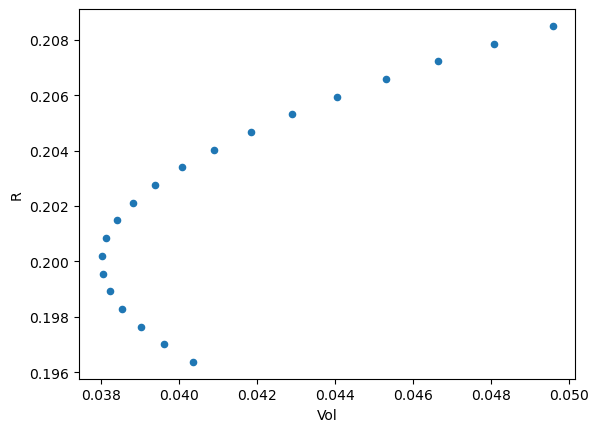

In [10]:
#Plot the efficient frontier
ef.plot.scatter(x="Vol", y="R")

<Axes: xlabel='Volatility'>

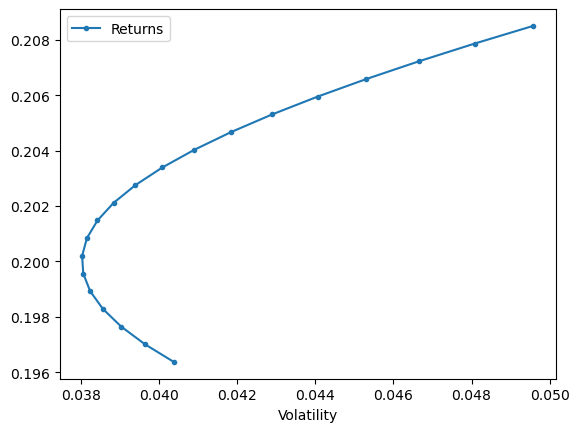

In [11]:
#Interpolate the efficient frontier
erk.plot_ef2(n_points, er[l_2], cov.loc[l_2,l_2])

## K-Asset Markowitz Portfolio:

In [13]:
#k-asset tangent portfolio weights
w_msr = erk.msr(rf, er[l], cov.loc[l,l])
w_msr_rounded = np.round(w_msr,4)
er_rounded = np.round(er[l],2)
MarkowitzPortfolio_k = pd.DataFrame({'Absolute Return': er_rounded, 'Tangent Weight': w_msr_rounded})
MarkowitzPortfolio_k

,Absolute Return,Tangent Weight
Books,0.10,0.0
Steel,0.10,1.0
Oil,0.03,0.0
Mines,0.01,0.0


In [14]:
#Report annualized Tangent Portfolio metrics
ret = erk.portfolio_return(w_msr, er[l])
vol = erk.portfolio_vol(w_msr, cov.loc[l,l])
print("Ret:", round(erk.portfolio_return(w_msr, er[l])*100,2))
print("Vol:", round(erk.portfolio_vol(w_msr, cov.loc[l,l])*100,2))
print("Sharpe:", round((ret-rf)/vol,2))

Ret: 10.07
Vol: 6.63
Sharpe: 0.01


In [15]:
#k-asset Global Minimum Variance portfolio weights
w_gmv = erk.gmv(cov.loc[l,l])
w_gmv_rounded = np.round(w_gmv,4)
er_rounded = np.round(er[l],2)
MinimumVarPortfolio_k = pd.DataFrame({'Absolute Return': er_rounded, 'GMV Weight': w_gmv_rounded})
MinimumVarPortfolio_k

,Absolute Return,GMV Weight
Books,0.10,0.4770
Steel,0.10,0.0000
Oil,0.03,0.4341
Mines,0.01,0.0889


In [16]:
#Report annualized Minimum Variance Portfolio metrics
ret = erk.portfolio_return(w_gmv, er[l])
vol = erk.portfolio_vol(w_gmv, cov.loc[l,l])
print("Ret:", round(erk.portfolio_return(w_gmv, er[l])*100,2))
print("Vol:", round(erk.portfolio_vol(w_gmv, cov.loc[l,l])*100,2))
print("Sharpe:", round((ret-rf)/vol,2))

Ret: 5.69
Vol: 4.63
Sharpe: -0.93


## Finding the Maximum Sharpe Ratio Portfolio (MSR) aka Tangent Portfolio:

<Axes: xlabel='Volatility'>

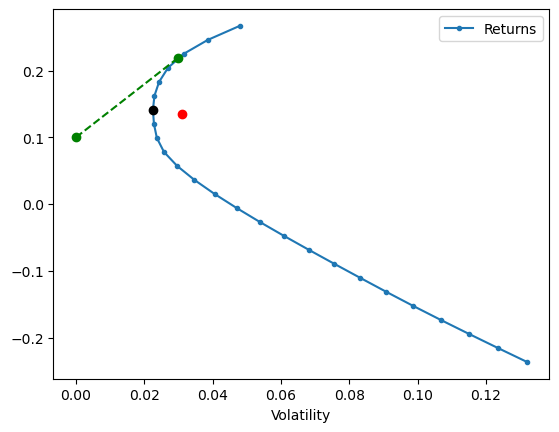

In [17]:
#Plot the efficient frontier for all assets in our dataset (30 in total) with 25 points
erk.plot_ef(25, er, cov, riskfree_rate=rf, min=min_allocation, max=max_allocation, optimizer=solver)

In [18]:
#tangent portfolio: rounded asset weights for all 30 assets
w_msr = erk.msr(rf, er, cov, min=min_allocation, max=max_allocation, optimizer=solver)
w_msr_rounded = np.round(w_msr,2)
er_rounded = np.round(er,2)
MarkowitzPortfolio = pd.DataFrame({'Absolute Return': er_rounded, 'Optimal Weight': w_msr_rounded})
MarkowitzPortfolio


,Absolute Return,Optimal Weight
Food,0.12,0.00
Beer,0.18,0.25
Smoke,0.17,0.05
Games,0.21,0.00
Books,0.10,0.00
Hshld,0.10,0.00
Clths,0.13,0.00
Hlth,0.17,0.00
Chems,0.16,0.00
Txtls,0.27,0.28


In [19]:
#Report annualized Tangent Portfolio metrics
ret = erk.portfolio_return(w_msr, er)
vol = erk.portfolio_vol(w_msr, cov)
print("Ret:", round(erk.portfolio_return(w_msr, er)*100,2))
print("Vol:", round(erk.portfolio_vol(w_msr, cov)*100,2))
print("Sharpe:", round((ret-rf)/vol,2))

Ret: 21.91
Vol: 2.99
Sharpe: 3.98


## Tackling estimation error in Markowitz

- option 1: come up with more reliable estimates of expected return
- option 2: focus on the minimum-variance portfolio
- option 3: create an equally-weighted portfolio (naieve diversificaiton)
- option 4: create a randomly-weighted portfolio

#### Option 2: Finding the minimum-variance portfolio

In [20]:
w_gmv = erk.gmv(cov)
w_gmv_rounded = np.round(w_gmv,2)
er_rounded = np.round(er,2)
MinimumVarPortfolio_k = pd.DataFrame({'Absolute Return': er_rounded, 'GMV Weight': w_gmv_rounded})
MinimumVarPortfolio_k

,Absolute Return,GMV Weight
Food,0.12,0.00
Beer,0.18,0.17
Smoke,0.17,0.00
Games,0.21,0.00
Books,0.10,0.00
Hshld,0.10,0.00
Clths,0.13,0.20
Hlth,0.17,0.00
Chems,0.16,0.00
Txtls,0.27,0.00


In [21]:
#Report annualized Minimum Variance Portoflio metrics
ret = erk.portfolio_return(w_gmv, er)
vol = erk.portfolio_vol(w_gmv, cov)
print("Ret:", round(erk.portfolio_return(w_gmv, er)*100,2))
print("Vol:", round(erk.portfolio_vol(w_gmv, cov)*100,2))
print("Sharpe:", round((ret-rf)/vol,2))

Ret: 14.16
Vol: 2.25
Sharpe: 1.85
